In [32]:
import torch
import PIL
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
import torch.nn as nn

import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### **Understanding What Our Transforms Do**

1. Our Transforms are applied to an image or batch of images everytime it's loaded.
2. These new images aren't saved, they're generated or 'altered' everytime a batch is loaded

#### **NOTE** 

We don't apply the same augmentations to our Test or Validation Datasets. Therefore, we keep separate transformation functions (see below) for our Train and Validation/Test data.

In [33]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomAffine(degrees = 10, translate = (0.05,0.05), shear = 5), 
        transforms.ColorJitter(hue = .05, saturation = .05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15, interpolation = PIL.Image.BILINEAR),
        transforms.Grayscale(num_output_channels = 1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, )),
    ]),
    'val':transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, ))
    ])

}

c:\Users\saeid\anaconda3\envs\pytorch\lib\site-packages\torchvision\transforms\transforms.py:1303: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [34]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])

In [35]:
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testLoader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

### **Adding Dropout**

In Convolutional Neural Networks Dropout is commonly added after CONV-RELU Layers.

E.g. CONV->RELU->**DROPOUT**

#### **Dropout Recommendations** 

In CNN's values of 0.1 to 0.3 have been found to work well.

### **Adding BatchNorm**

In CNNs **BatchNorm** is best used between the Conv Layer and the activation function layer (ReLU)
When used with Dropout, the recommended order is: 

CONV_1 -> **BatchNorm** -> ReLU -> Dropout - CONV_2

**NOTE** BatchNorm's input arguement is the **output** size of the previous layer.

In [46]:
class FMnistClassifier(nn.Module):
    def __init__(self):
        super(FMnistClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv1_bn = nn.BatchNorm2d(32) 
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv2_bn = nn.BatchNorm2d(64) 
        self.maxpool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64 * 12 * 12 , 128)       # input image is 28 x 28
        self.fc2 = nn.Linear(128, 10)
        self.dropOut = nn.Dropout(0.2)           # We can apply this after any layer, but it's best suited after ReLU
    
    
    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))      # CONV_1 -> BatchNorm -> ReLU -> Dropout - CONV_2
        x = self.dropOut(x)
        x = self.dropOut(F.relu(self.conv2_bn(self.conv2(x))))

        x = self.maxpool(x)
        x = x.view(-1, 64 * 12 * 12)   # we use -1 bcz we want our code to be flexible enough to handle batches of different sizes
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = FMnistClassifier()
net.to(device)

FMnistClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropOut): Dropout(p=0.2, inplace=False)
)

### **Adding L2 Regularisation**


L2 regularisation on the parameters/weights of the model is directly included in most optimizers, including optim.SGD.

It can be controlled with the **weight_decay** parameter as can be seen in the [SGD documentation](http://pytorch.org/docs/optim.html#torch.optim.SGD).

```weight_decay``` (**float**, optional) – weight decay *(L2 penalty) (default: 0)*

**Good L2 Values range from 0.1 to 0.0001**

**NOTE:**

 L1 regularization is not included by default in the optimizers, but could be added by including an extra loss nn.L1Loss in the weights of the model.



In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.001)

In [48]:
epochs = 15

epoch_log = []
accuracy_log = []
loss_log = []

for epoch in range(epochs):
    print(f'starting epoch : {epoch +1}...')

    running_loss = 0.0

    for i , data in enumerate(trainLoader, 0):

        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)


        optimizer.zero_grad()

        output = net(inputs)

        loss = criterion(output, labels)
        loss.backward()

        optimizer.step()
        running_loss += loss.item()

        if i % 100 == 99:

            correct = 0
            total = 0
            
            with torch.no_grad():

                for data in testLoader:

                    images , labels = data

                    images = images.to(device)
                    labels = labels.to(device)

                    output = net(images)

                    _, predict = torch.max(output.data, 1)

                    correct += (predict == labels).sum().item()
                    total += labels.size(0)

                accuracy = (correct/total) * 100
                epoch_num = epoch + 1
                actual_loss = running_loss / 100 # represents the average loss over 100 mini-batches
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                running_loss = 0.0



    epoch_log.append(epoch)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)

print('Finished Training')        


starting epoch : 1...
Epoch: 1, Mini-Batches Completed: 100, Loss: 1.216, Test Accuracy = 70.860%
Epoch: 1, Mini-Batches Completed: 200, Loss: 0.831, Test Accuracy = 73.340%
Epoch: 1, Mini-Batches Completed: 300, Loss: 0.770, Test Accuracy = 76.910%
Epoch: 1, Mini-Batches Completed: 400, Loss: 0.699, Test Accuracy = 78.360%
Epoch: 1, Mini-Batches Completed: 500, Loss: 0.638, Test Accuracy = 77.600%
Epoch: 1, Mini-Batches Completed: 600, Loss: 0.637, Test Accuracy = 79.800%
Epoch: 1, Mini-Batches Completed: 700, Loss: 0.641, Test Accuracy = 80.280%
Epoch: 1, Mini-Batches Completed: 800, Loss: 0.601, Test Accuracy = 79.870%
Epoch: 1, Mini-Batches Completed: 900, Loss: 0.585, Test Accuracy = 80.950%
Epoch: 1, Mini-Batches Completed: 1000, Loss: 0.580, Test Accuracy = 81.800%
Epoch: 1, Mini-Batches Completed: 1100, Loss: 0.557, Test Accuracy = 80.810%
Epoch: 1, Mini-Batches Completed: 1200, Loss: 0.546, Test Accuracy = 82.630%
Epoch: 1, Mini-Batches Completed: 1300, Loss: 0.576, Test Accur

In [49]:
correct = 0 
total = 0

with torch.no_grad():
    for data in testLoader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.4}%')

Accuracy of the network on the 10000 test images: 89.74%


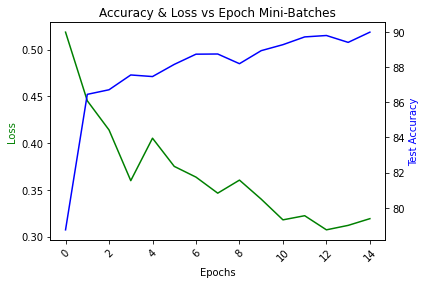

In [50]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

plt.title("Accuracy & Loss vs Epoch Mini-Batches")
plt.xticks(rotation=45)

ax2 = ax1.twinx()

ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

#### **Early Stopping in PyTorch**

https://github.com/Bjarten/early-stopping-pytorch